In [1]:
#Reservoir computing 
#              ________  
#              |       |     
#              V       |  
#input--->o--->o--->o  |
#         |    |    |  | 
#         V    V    V  |
##         o--->o--->o---
#         |    |    |
#         V    V    V)
#         o--->o--->o--->output
   
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from mpl_toolkits.mplot3d import Axes3D
from colormaps import viridis

from colormaps import magma

def sigmoid(z):
    #Returns the logistic of the value z
    mySig = 1 / (1+np.exp(-z))
    return mySig

def sigmoidGradient(z):
    #return the gradient of a sigmoid function at value z
    mySigGrad = sigmoid(z)*(1-sigmoid(z))
    return mySigGrad

def relu(z):
    myReLU= np.zeros(np.shape(z))
    for cx in range(np.shape(z)[0]):
        for cy in range(np.shape(z)[1]):
            x = z[cx,cy]
            if x > 0:
                myReLU[cx,cy] = x
            else:
                myReLU[cx,cy] = 0.0
    #myReLU = np.max(0,z)
    return np.array(myReLU)

def reLUGradient(z):
    myReLUGrad = np.zeros(len(z))
    for c in range(0,z):
        if (z[c] > 0):
            myReLUGrad[c] = 1.0
        else:
            myReLUGrad[c] = 0.0
            
        return myReLUGrad 
def cap(z0,z1):
    # Activation function based on a capacitor charge/discharge
    t = 3
    tau = 1
    fCap = (z1-z0) * (1-np.exp(-t/tau)) + z1
    return fCap

def tanh(z):
    myTanh = np.exp(z)/(np.exp(-z)+np.exp(z)) - np.exp(-z)/(np.exp(-z)+np.exp(z))
    return myTanh

def schmitt(z0,z1):
    # Based on a Schmitt trigger 
    # use tanh with hysteresis
    myTemp = tanh(z0)
    mySchmitt = tanh(myTemp+z1)
    return mySchmitt

In [3]:
import tensorflow as tf

In [7]:
help(tf.random_normal)

Help on function random_normal in module tensorflow.python.ops.random_ops:

random_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None)
    Outputs random values from a normal distribution.
    
    Args:
      shape: A 1-D integer Tensor or Python array. The shape of the output tensor.
      mean: A 0-D Tensor or Python value of type `dtype`. The mean of the normal
        distribution.
      stddev: A 0-D Tensor or Python value of type `dtype`. The standard deviation
        of the normal distribution.
      dtype: The type of the output.
      seed: A Python integer. Used to create a random seed for the distribution.
        See
        @{tf.set_random_seed}
        for behavior.
      name: A name for the operation (optional).
    
    Returns:
      A tensor of the specified shape filled with random normal values.



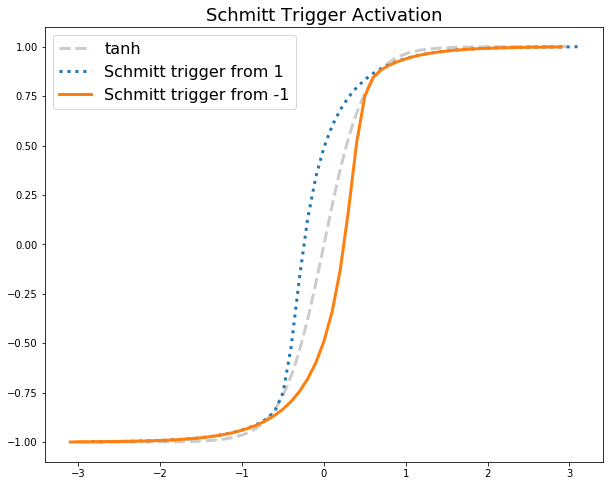

0.099667994625 0.697078110758


In [121]:
myR = 3
x = np.arange(-myR,myR,0.01)
myTest = tanh(x*2)
plt.figure(figsize=(10,8))
plt.plot(x,myTest,'--',lw=3,color=[0.8,0.8,0.8],label='tanh')

ck = np.arange(-5,5,0.01)
    
mySchmitty0 = [1]
mySchmitty1 = [-1]

for ck in np.arange(myR,-myR,-.1):
    mySchmitty0.append(schmitt(mySchmitty0[len(mySchmitty0)-1],ck))
for cl in np.arange(-myR,myR,.1):
    mySchmitty1.append(schmitt(mySchmitty1[len(mySchmitty1)-1],cl))

k = np.arange(myR+0.1,-myR,-.1)
l = np.arange(-myR-0.1,myR,.1)

plt.plot(k,mySchmitty0,':',lw=3,label='Schmitt trigger from 1')
plt.plot(l,mySchmitty1,'-',lw=3,label='Schmitt trigger from -1')
plt.title('Schmitt Trigger Activation',fontsize=18)
plt.legend(fontsize=16)
plt.savefig('./figs/schmittTrigger.png')
plt.show()
print(tanh(0.1),schmitt(1,0.1))


.


/home/main/anaconda3/envs/lV/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


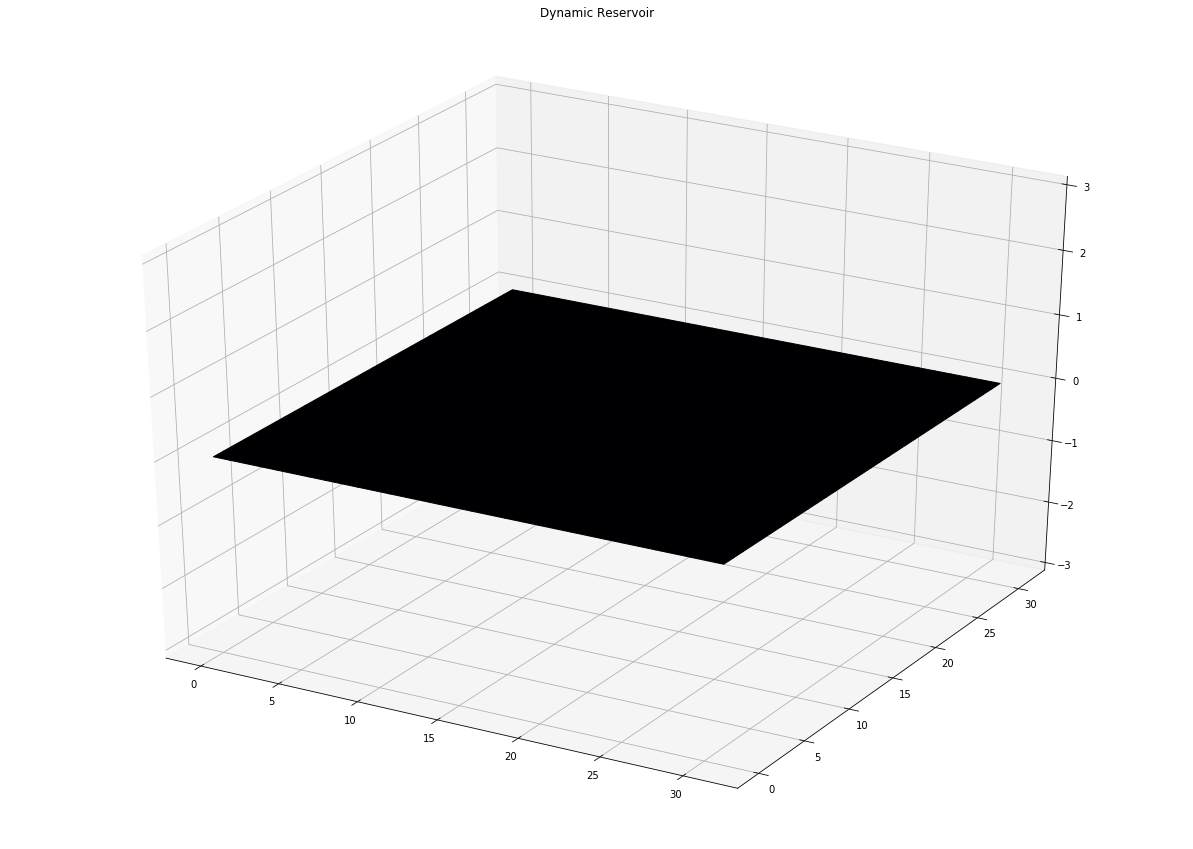

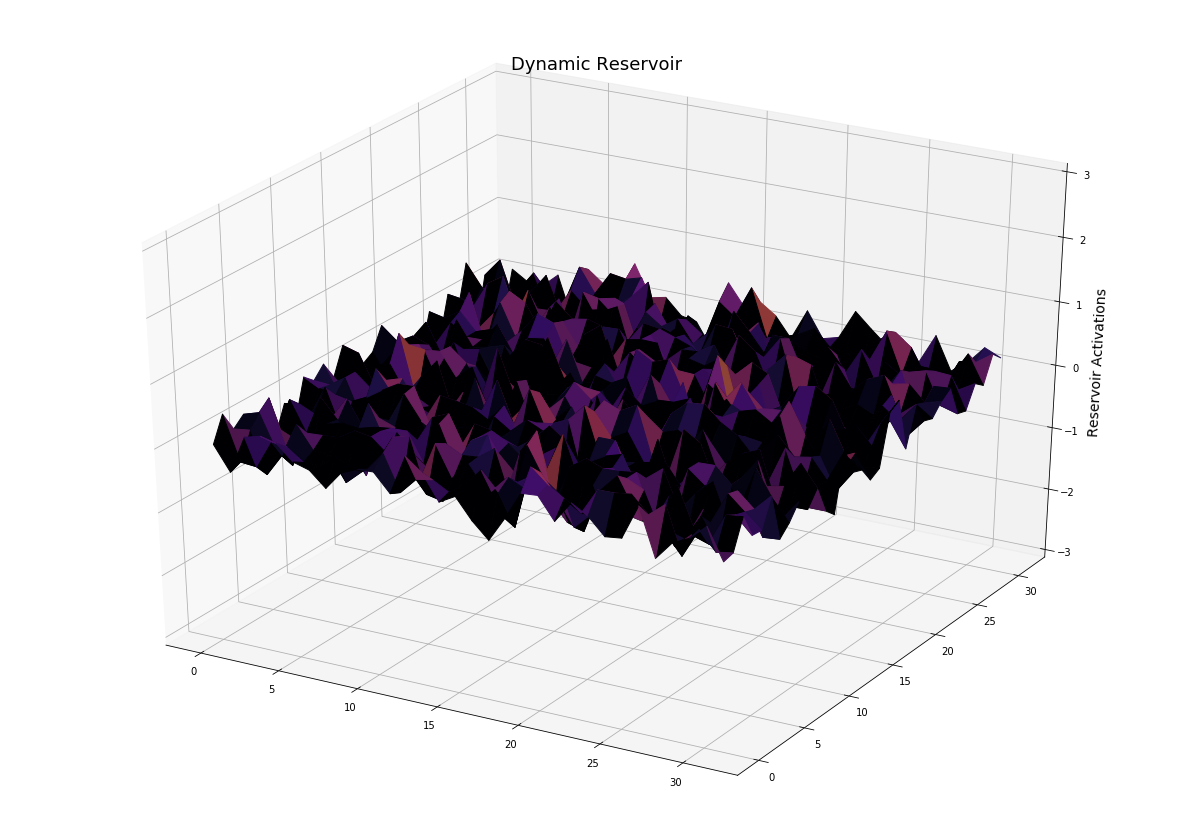

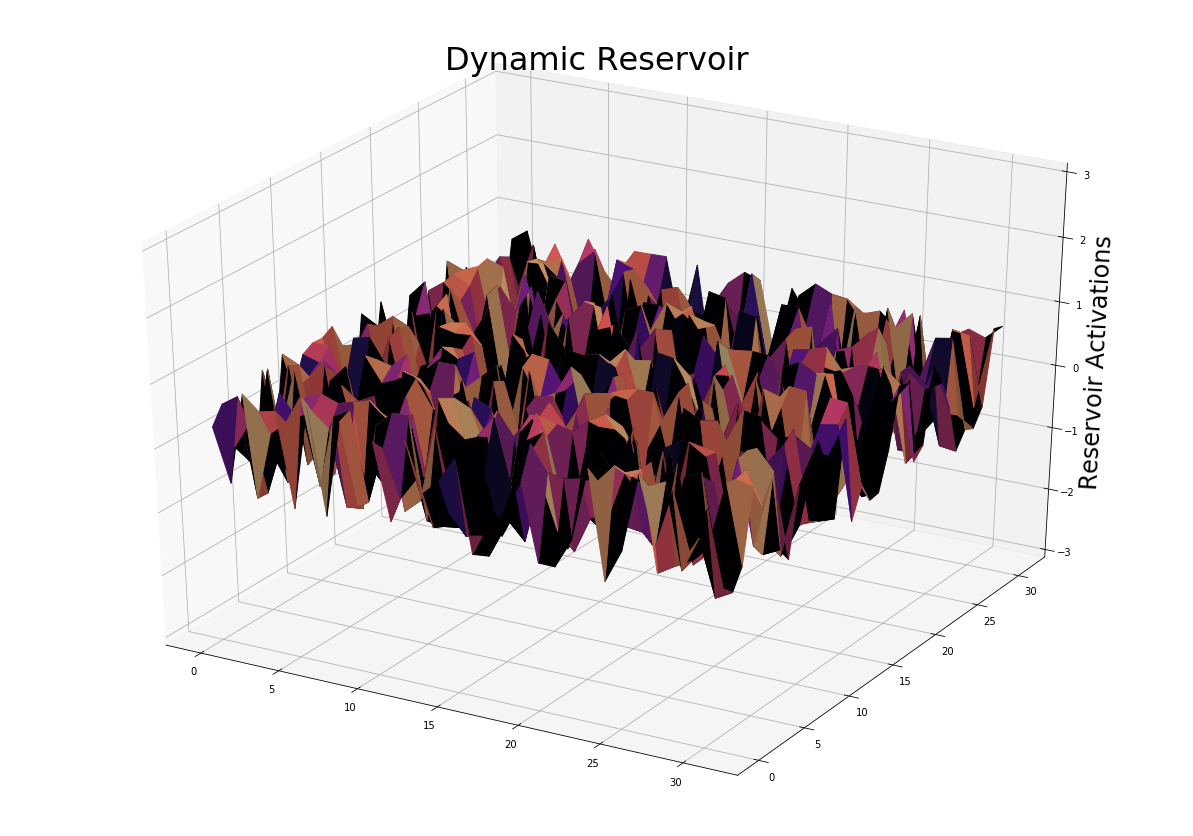

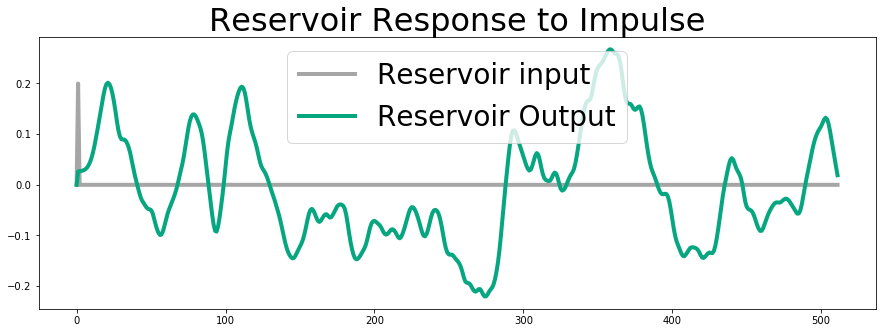

In [135]:
pi = 3.14159

# Parameters
    # random seed
mySeed = 10
myDim = 1024
mySqrt = int(np.sqrt(myDim))

# Sparsity coefficient
#spCh = 1.0
spCh = 0.75
# meta - Weight
#wtWt = 20.9500025/myDim**2
wtWt = 256*256/myDim**2
#for spCh in np.arange (0.1,1.0,0.1):
#    for wtWt in np.arange(0.75/myDim**2,2.0/myDim**2,0.25/myDim**2):
np.random.seed(mySeed)

# Layers
a0 = np.zeros((1,myDim))
a1 = np.zeros((1,myDim))
charTest = 0
if(charTest):
    vocabSize = 65
else:
    vocabSize=1
# Weights
    # input to a0
theta0 = 1e-2*np.random.random((myDim,vocabSize))
    # a0 to a0
thetaJ0_0 = wtWt * (np.random.random((myDim,myDim))-0.5) * (np.random.random((myDim,myDim)) < spCh)
    # a0 to a1
thetaJ0_1 = wtWt * (np.random.random((myDim,myDim))-0.5) * (np.random.random((myDim,myDim)) < spCh)
    # a1 to a0
thetaJ1_0 =  wtWt*(np.random.random((myDim,myDim))-0.5) * (np.random.random((myDim,myDim)) < spCh)
    # a1 to a1
thetaJ1_1 = wtWt * (np.random.random((myDim,myDim))-0.5) * (np.random.random((myDim,myDim)) < spCh)
    # a1 to output
theta1 =  1e-2*np.random.random((vocabSize,myDim))
if(charTest):
    myLen = 1024
    mySigTemp = np.random.random((myLen,vocabSize))
    mySig = np.zeros((myLen,vocabSize))
    for m in range(myLen):
        mySig[m,np.argmax(mySigTemp[m,:])] = 1
    mySig = np.append(mySig,np.zeros((myLen,vocabSize)),axis=0)
    myLen = myLen*2
elif(1):
    myLen = 512
    mySig = np.zeros(myLen)

    if(0):
        x = np.arange(0,6*pi,6*pi/myLen)
        mySig = np.sin(4*x)#+np.sin(2*x)+np.sin(x) + np.exp(np.random.random(myLen)*1j*2*pi)
        
    #mySig[2:3] = 1
    mySig[1:2] = 1
    
    #mySig[120:121] = -1
    
    #mySig[200:300] = 1
elif(1):
    myLen = 131172 
    myRate,mySig = wavfile.read('/media/main/USB Stick/kaggle/tensorFlowSpeech/train/audio/_background_noise_/dude_miaowing.wav')
    mySig = mySig[0:myLen]
    print('rate %.3f' %myRate)
mySigOut = []
    
myMax = 3.0
for l in range(len(mySig)):
    a0 = (schmitt(a0,np.dot(mySig[l],theta0.T) + np.dot(a0,thetaJ0_0.T)))# +  np.dot(a1,thetaJ1_0.T))
    #a1 = (schmitt(a1,np.dot(a0,thetaJ0_1.T)+ np.dot(a1,thetaJ1_1.T)))
    #print(np.argmax(np.reshape(np.dot(a1,theta1.T),vocabSize)))
    if(charTest):
        mySigOut.append(np.argmax(np.reshape((np.dot(a0,theta1.T)),vocabSize)))
    else:
        mySigOut.append(np.dot(a0,theta1.T))
    if(0):
        if l == 0:
            mySigOut.append(np.argmax(np.reshape(cap(0,np.dot(a1,theta1.T)),vocabSize)))
        else:
            mySigOut.append(np.argmax(np.reshape(cap(mySigOut[l-1],np.dot(a1,theta1.T)),vocabSize)))#**2
    if (l % 10000 == 0):
        print('.')
    if(1):#l % 1 == 0 ):
        
    

        fig = plt.figure(figsize=(21,15))
        ax = fig.add_subplot(111, projection='3d')
        x = y = np.arange(0,mySqrt)
        X, Y = np.meshgrid(x, y)
        #zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
        Z = a0.reshape((mySqrt,mySqrt))
        #print(np.shape(X),np.shape(Y),np.shape(Z))
        ax.plot_surface(X, Y, Z,facecolors=magma(Z))
        ax.set_zlim(-myMax,myMax)
        ax.set_title('Dynamic Reservoir',fontsize=36)
        #ax.set_zlabel('Reservoir Activations',fontsize=24)
        plt.savefig('./dynRes/dynReservoir%i.png'%l)
        #plt.show()
        plt.clf()
    if(0):
        plt.figure(figsize=(10,10))
        plt.subplot(121)
        plt.imshow(np.reshape(np.real(a0**2),(mySqrt,mySqrt)))
        plt.subplot(122)
        plt.imshow(np.reshape(np.real(a1**2),(mySqrt,mySqrt)))
        
        plt.savefig('./dynReservoir%i.png'%l)
        #plt.show()
        plt.clf()
        

np.shape(mySigOut)
#mySigOut = np.array(1e3*(mySigOut/np.max(mySigOut)))
plt.figure(figsize=(15,5))
plt.plot(mySig/5,'-',color=[0.65,0.65,0.65],lw=4,label='Reservoir input')
plt.plot(np.reshape(mySigOut,(myLen,1)),'-',color=[0.025,0.65,0.5],lw=4,label='Reservoir Output')
plt.legend(fontsize=28)
plt.title('Reservoir Response to Impulse',fontsize=32)
plt.show()
plt.clf()
if(0):
    wavfile.write('./testIn.wav',myRate,mySig)

    wavfile.write('./testOut.wav',myRate,mySigOut)

In [137]:
plt.close('all')

In [ ]:
pi = 3.14159

# Parameters
    # random seed
mySeed = 10
myDim = 1024
mySqrt = int(np.sqrt(myDim))

# Sparsity coefficient
spCh = 1.0
# meta - Weight
wtWt = 20.9500025/myDim**2
#for spCh in np.arange (0.1,1.0,0.1):
#    for wtWt in np.arange(0.75/myDim**2,2.0/myDim**2,0.25/myDim**2):
np.random.seed(mySeed)

# Layers
a0 = np.zeros((1,myDim))
a1 = np.zeros((1,myDim))

vocabSize = 65
# Weights
    # input to a0
theta0 = np.random.random((myDim,vocabSize))
    # a0 to a0
thetaJ0_0 = wtWt * (np.random.random((myDim,myDim))-0.5) * (np.random.random((myDim,myDim)) < spCh)
    # a0 to a1
thetaJ0_1 = wtWt * (np.random.random((myDim,myDim))-0.5) * (np.random.random((myDim,myDim)) < spCh)
    # a1 to a0
thetaJ1_0 =  wtWt*(np.random.random((myDim,myDim))-0.5) * (np.random.random((myDim,myDim)) < spCh)
    # a1 to a1
thetaJ1_1 = wtWt * (np.random.random((myDim,myDim))-0.5) * (np.random.random((myDim,myDim)) < spCh)
    # a1 to output
theta1 =  np.random.random((vocabSize,myDim))
if(1):
    myLen = 256
    mySigTemp = np.random.random((myLen,vocabSize))
    mySig = np.zeros((myLen,vocabSize))
    for m in range(myLen):
        mySig[m,np.argmax(mySigTemp[m,:])] = 1
    mySig = np.append(mySig,np.zeros((myLen,vocabSize)),axis=0)
    myLen = 512
elif(1):
    myLen = 128
    mySig = np.zeros(myLen)

    if(0):
        x = np.arange(0,6*pi,6*pi/myLen)
        mySig = np.sin(4*x)#+np.sin(2*x)+np.sin(x) + np.exp(np.random.random(myLen)*1j*2*pi)
        
    mySig[2:3] = 1
    mySig[22:23] = 1
    
    #mySig[200:300] = 1
elif(1):
    myLen = 131172 
    myRate,mySig = wavfile.read('/media/main/USB Stick/kaggle/tensorFlowSpeech/train/audio/_background_noise_/dude_miaowing.wav')
    mySig = mySig[0:myLen]
    print('rate %.3f' %myRate)
mySigOut = []
    

for l in range(len(mySig)):
    a0 = (cap(a0,np.dot(mySig[l],theta0.T) + np.dot(a0,thetaJ0_0.T)) +  np.dot(a1,thetaJ1_0.T))
    a1 = (cap(a1,np.dot(a0,thetaJ0_1.T)+ np.dot(a1,thetaJ1_1.T)))
    #print(np.argmax(np.reshape(np.dot(a1,theta1.T),vocabSize)))
    mySigOut.append(np.argmax(np.reshape((np.dot(a1,theta1.T)),vocabSize)))
    if(0):
        if l == 0:
            mySigOut.append(np.argmax(np.reshape(cap(0,np.dot(a1,theta1.T)),vocabSize)))
        else:
            mySigOut.append(np.argmax(np.reshape(cap(mySigOut[l-1],np.dot(a1,theta1.T)),vocabSize)))#**2
    if (l % 10000 == 0):
        print('.')
    if(l % 100 == 0 ):
        plt.figure(figsize=(10,20))
        plt.subplot(121)
        plt.imshow(np.reshape(np.real(a0**2),(mySqrt,mySqrt)))
        plt.subplot(122)
        plt.imshow(np.reshape(np.real(a1**2),(mySqrt,mySqrt)))
        plt.show()
        #plt.savefig('./testFig%i.png'%l)
        #plt.clf()

np.shape(mySigOut)
#mySigOut = np.array(1e3*(mySigOut/np.max(mySigOut)))
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(mySig)
plt.subplot(212)
plt.plot(np.reshape(mySigOut,(myLen,1)))
print(spCh,wtWt)
plt.show()
plt.clf()
if(0):
    wavfile.write('./testIn.wav',myRate,mySig)

    wavfile.write('./testOut.wav',myRate,mySigOut)

.
1.0 0.00031967166900634766


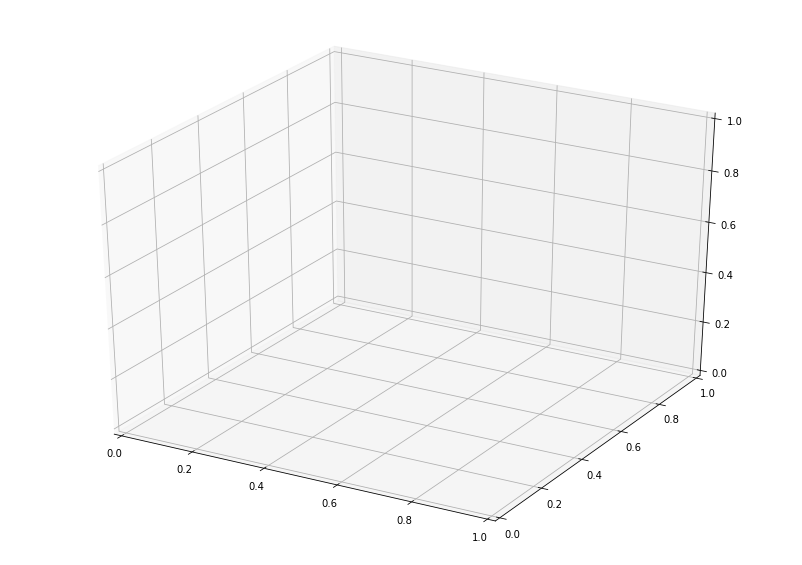

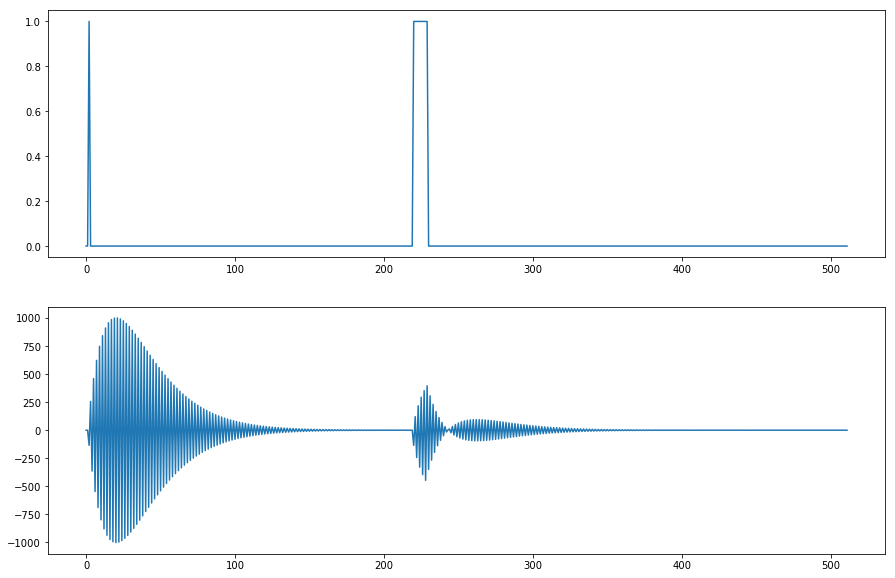

In [70]:
pi = 3.14159

# Parameters
    # random seed
mySeed = 1
myDim = 256
mySqrt = int(np.sqrt(myDim))

# Sparsity coefficient
spCh = 1.0
# meta - Weight
wtWt = 20.9500025/myDim**2
#for spCh in np.arange (0.1,1.0,0.1):
#    for wtWt in np.arange(0.75/myDim**2,2.0/myDim**2,0.25/myDim**2):
np.random.seed(mySeed)

# Layers
a0 = np.zeros((1,myDim))
a1 = np.zeros((1,myDim))

vocAbSize = 65
# Weights
    # input to a0
theta0 = np.random.random((myDim,vocabSize))
    # a0 to a0
thetaJ0_0 = wtWt * (np.random.random((myDim,myDim))-0.5) * (np.random.random((myDim,myDim)) < spCh)
    # a0 to a1
thetaJ0_1 = wtWt * (np.random.random((myDim,myDim))-0.5) * (np.random.random((myDim,myDim)) < spCh)
    # a1 to a0
thetaJ1_0 =  wtWt*(np.random.random((myDim,myDim))-0.5) * (np.random.random((myDim,myDim)) < spCh)
    # a1 to a1
thetaJ1_1 = wtWt * (np.random.random((myDim,myDim))-0.5) * (np.random.random((myDim,myDim)) < spCh)
    # a1 to output
theta1 =  np.random.random((1,myDim))
if(0):
    myLen = 512
    mySig = np.random.random(vocabSize)
elif(1):
    myLen = 512
    mySig = np.zeros(myLen)

    if(0):
        x = np.arange(0,6*pi,6*pi/myLen)
        mySig = np.sin(4*x)#+np.sin(2*x)+np.sin(x) + np.exp(np.random.random(myLen)*1j*2*pi)
        
    mySig[2:3] = 1
    mySig[220:230] = 1
        
    #mySig[200:300] = 1
elif(1):
    myLen = 131172 
    myRate,mySig = wavfile.read('/media/main/USB Stick/kaggle/tensorFlowSpeech/train/audio/_background_noise_/dude_miaowing.wav')
    mySig = mySig[0:myLen]
    print('rate %.3f' %myRate)
mySigOut = []
    

for l in range(len(mySig)):
    a0 = (cap(a0,np.dot(mySig[l],theta0.T) + np.dot(a0,thetaJ0_0.T)) +  np.dot(a1,thetaJ1_0.T))
    a1 = (cap(a1,np.dot(a0,thetaJ0_1.T)+ np.dot(a1,thetaJ1_1.T)))
    mySigOut.append(np.dot(a1,theta1.T))#**2
    if (l % 10000 == 0):
        print('.')
    if(0):#l % 100 == 0 ):
        plt.figure(figsize=(10,20))
        plt.subplot(121)
        plt.imshow(np.reshape(np.real(a0**2),(mySqrt,mySqrt)))
        plt.subplot(122)
        plt.imshow(np.reshape(np.real(a1**2),(mySqrt,mySqrt)))
        plt.show()
        #plt.savefig('./testFig%i.png'%l)
        #plt.clf()

np.shape(mySigOut)
mySigOut = np.array(1e3*(mySigOut/np.max(mySigOut)))
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(mySig)
plt.subplot(212)
plt.plot(np.reshape(mySigOut,(myLen,1)))
print(spCh,wtWt)
plt.show()
plt.clf()
if(0):
    wavfile.write('./testIn.wav',myRate,mySig)

    wavfile.write('./testOut.wav',myRate,mySigOut)

In [5]:
print(np.max(mySig))
print(np.max(mySigOut))
if(1):
    wavfile.write('./testIn.wav',myRate,mySig)

    wavfile.write('./testOut.wav',myRate,mySigOut)

1662
1000.0


(64, 1) 
 (64, 64) 
 (1, 64) 

(64, 64) 
 (64, 64) 



/home/main/anaconda3/envs/lV/lib/python3.6/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
/home/main/anaconda3/envs/lV/lib/python3.6/site-packages/ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
/home/main/anaconda3/envs/lV/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


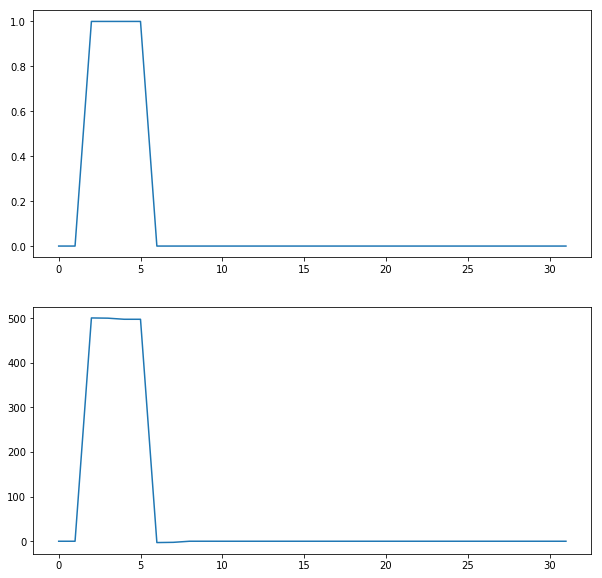

In [259]:
import numpy as np
import matplotlib.pyplot as plt
pi = 3.14159
myDim = 64
myLen = 32
a0 = np.zeros((1,myDim))
a1 = np.zeros((1,myDim))
a00 = np.zeros((1,myDim))
spCh = 0.95
# weights from input to first pile
theta0 = np.random.random((myDim,1))
theta00 = spCh*np.random.random((myDim,myDim))*np.exp(2*pi*1j*np.random.random((myDim,myDim)))\
* (np.random.random((myDim,myDim))>0.10)
theta00 = theta00/myDim
# weights from first pile to first pile
thetaJ0 = (np.random.random((myDim,myDim))>spCh)*np.random.random((myDim,myDim))*np.exp(2*pi*1j*np.random.random((myDim,myDim)))\

thetaJ0 = thetaJ0/myDim
thetaJ00 = (np.random.random((myDim,myDim))>spCh)*np.random.random((myDim,myDim))*np.exp(2*pi*1j*np.random.random((myDim,myDim)))\

thetaJ00 = thetaJ00/myDim
#weights from 1st to 2nd pile
theta1 = np.random.random((myDim,myDim))
# weights from 2nd pile to 2nd pile
thetaJ1 = (np.random.random((myDim,myDim))>0.10)*np.random.random((myDim,myDim))*np.exp(2*pi*1j*np.random.random((myDim,myDim)))\

thetaJ1 = thetaJ1/myDim
#weights to output
theta2 = np.random.random((1,myDim))

print(np.shape(theta0),'\n',np.shape(theta1),'\n',np.shape(theta2),'\n')

print(np.shape(thetaJ0),'\n',np.shape(thetaJ1),'\n')


mySig = np.zeros(myLen)

if(0):
    x = np.arange(0,6*pi,6*pi/myLen)
    mySig = np.sin(4*x)+np.sin(2*x)+np.sin(x) + np.exp(np.random.random(myLen)*1j*2*pi)

mySig[2:6] = 1+10*1j
mySig[6:12] = -1j
mySigOut = []
mySqrt = int(np.sqrt(myDim))
for l in range(myLen):
    #print(np.shape(np.dot(a0.T,thetaJ0.T)))
    #print(np.shape(np.dot(mySig[l],theta0)))
    
    a0 = (np.dot(mySig[l],theta0.T) + np.dot(a0,thetaJ0.T)) +  np.dot(a00,thetaJ00.T)
    a00 = (np.dot(a1,theta00.T))
    a1 = (np.dot(a0,theta1.T) + np.dot(a1,thetaJ1.T))
    #print(np.shape(a1))
    mySigOut.append(np.dot(a1,theta2.T))#**2
    if(0):
        plt.figure()
        plt.subplot(121)
        plt.imshow(np.reshape(np.real(a0**2),(mySqrt,mySqrt)))
        plt.subplot(122)
        plt.imshow(np.reshape(np.real(a1**2),(mySqrt,mySqrt)))

np.shape(mySigOut)

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(mySig)
plt.subplot(212)
plt.plot(np.reshape(mySigOut,(myLen,1)))
plt.show()

In [257]:
whos

Variable          Type        Data/Info
---------------------------------------
a0                ndarray     1x64: 64 elems, type `float64`, 512 bytes
a00               ndarray     1x64: 64 elems, type `complex128`, 1024 bytes
a1                ndarray     1x64: 64 elems, type `float64`, 512 bytes
cap               function    <function cap at 0x7fce7ab1b048>
l                 int         131171
myDim             int         64
myLen             int         131172
myRate            int         16000
mySeed            int         1337
mySig             ndarray     131172: 131172 elems, type `int16`, 262344 bytes (256.1953125 kb)
mySigOut          list        n=131172
mySqrt            int         8
np                module      <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
pi                float       3.14159
plt               module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
reLU              function    <function reLU at 0x7fce7ee55378>
reLUGradient      

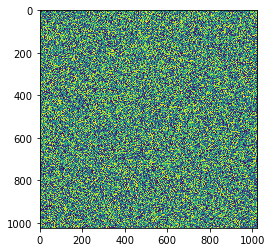

In [20]:
import numpy as np
import matplotlib.pyplot as plt
pi = 3.14159
myDim = 1024
#i = np.sqrt(-1)
myNodes = 0.0*np.random.random((myDim,1))# *np.exp(1j*np.random.random((myDim,1)))* 0.01
thetaJ = np.random.random((myDim,myDim))/myDim #*np.exp(1j*np.random.random((myDim,myDim))) / (myDim**2)
#thetaJ[np.random.random((myDim,myDim))] = 0
theta1 = np.random.random((8,1))

x = np.arange(0,6*pi,0.5)
mySig = np.sin(x)
#mySig = np.append(mySig,0*np.sin(10*x))

#mySig = np.append(mySig,np.sin(10*x))
mySigD = mySig *0
mySigD[6:10] = 5
if(0):
    plt.figure()
    plt.plot(mySig)
    plt.show()
#print(len(mySig))
plt.figure()
plt.imshow(thetaJ)
plt.show()
#print(thetaJ)

In [15]:
print(np.shape(myNodes),np.shape(thetaJ))

(1024, 1) (1024, 1024)


/home/main/anaconda3/envs/lV/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


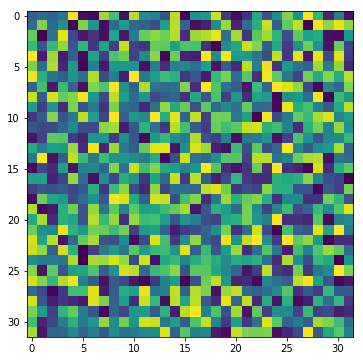

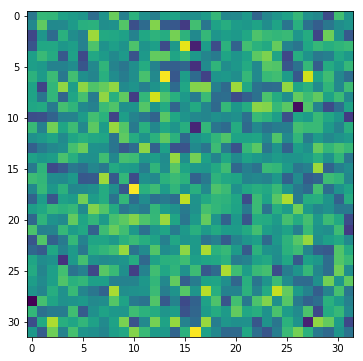

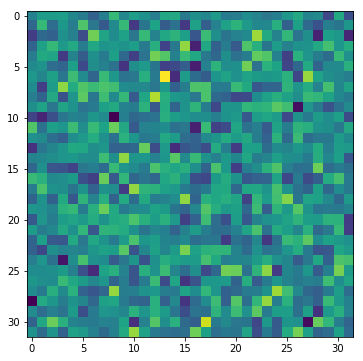

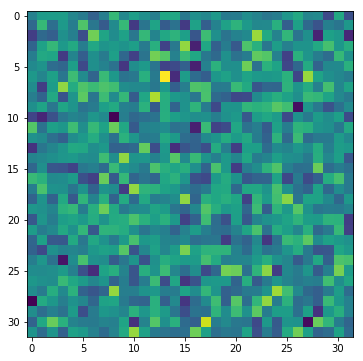

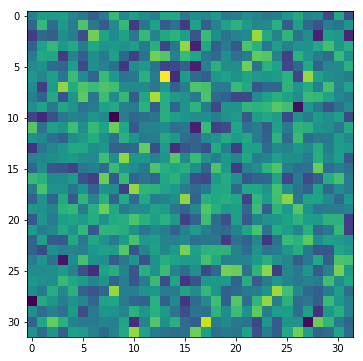

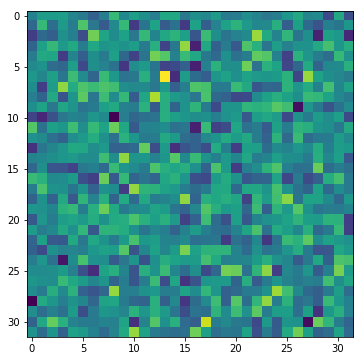

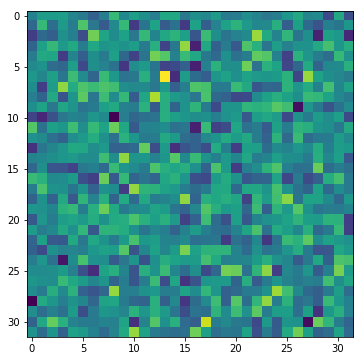

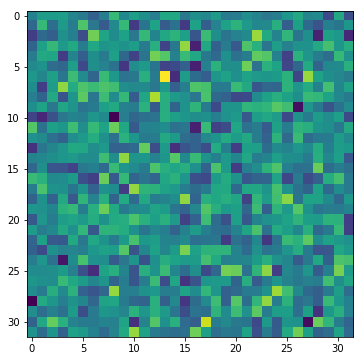

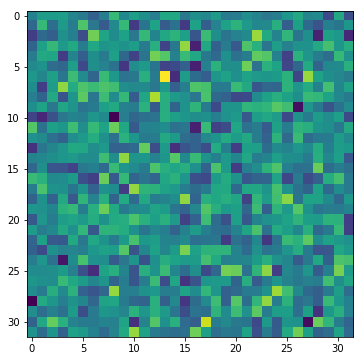

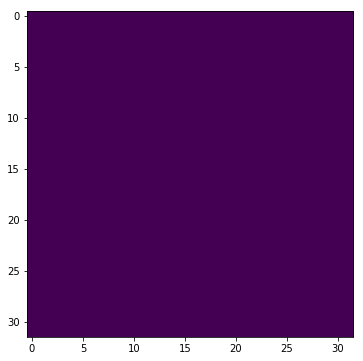

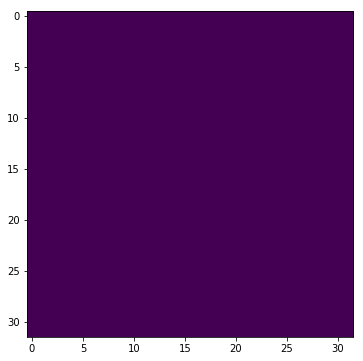

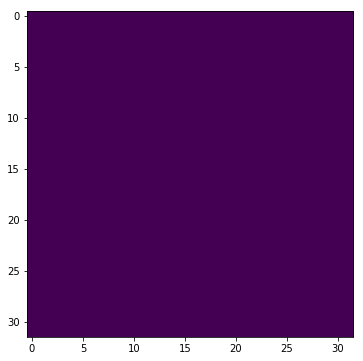

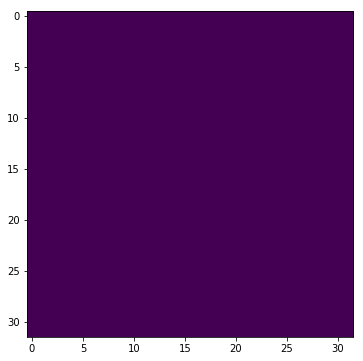

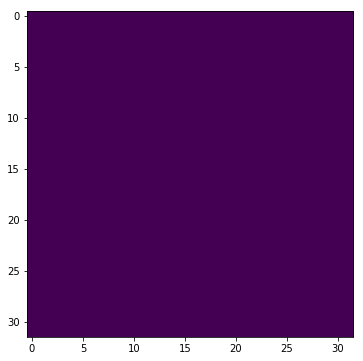

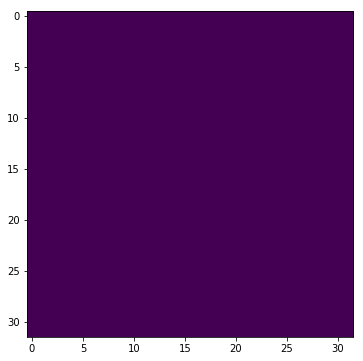

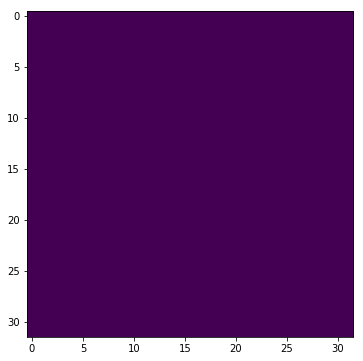

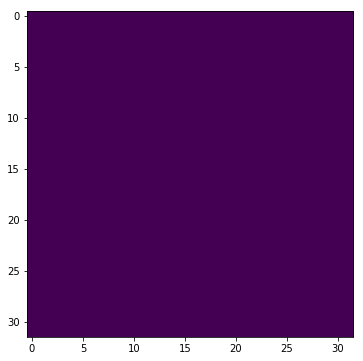

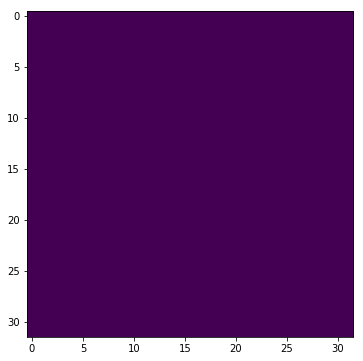

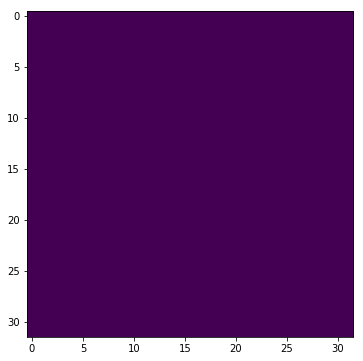

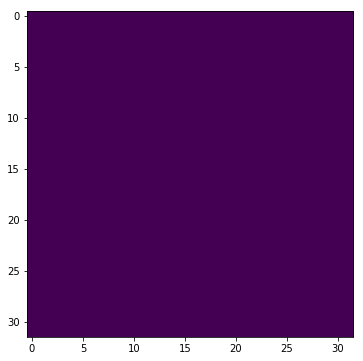

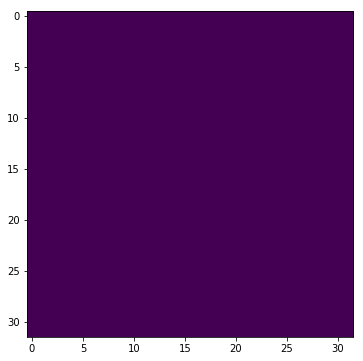

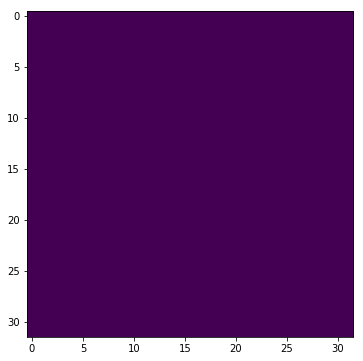

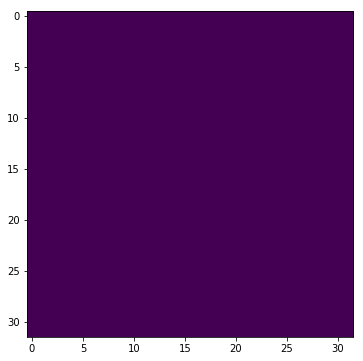

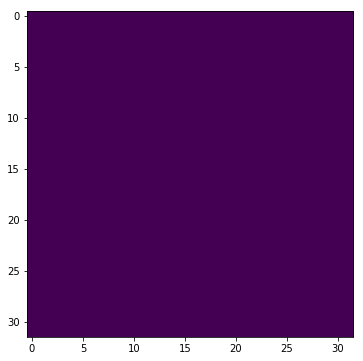

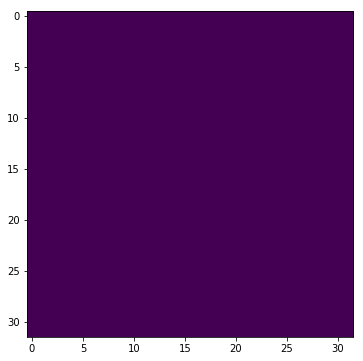

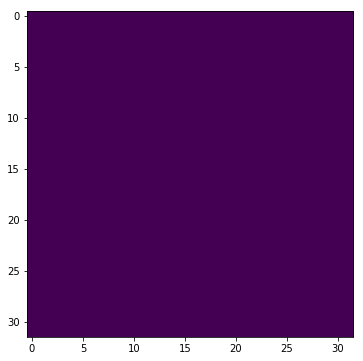

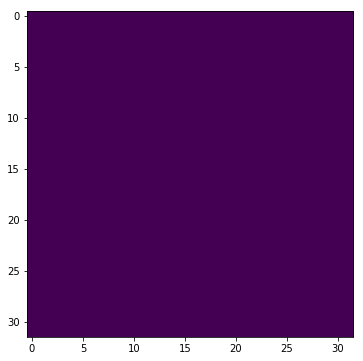

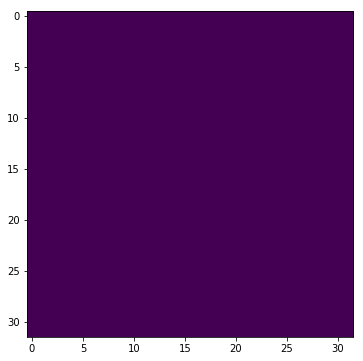

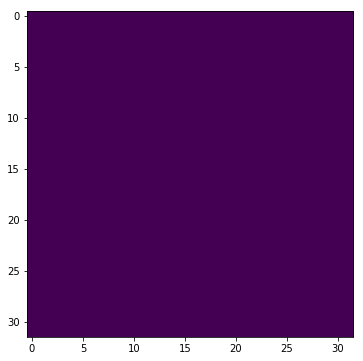

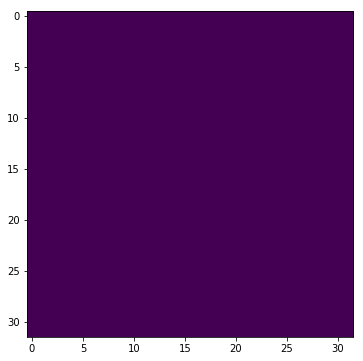

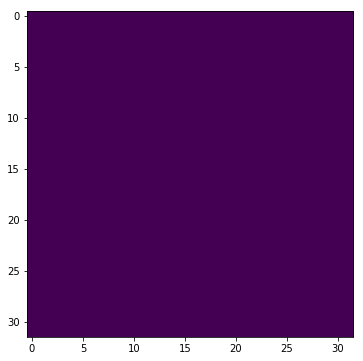

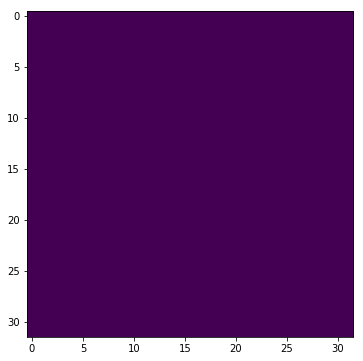

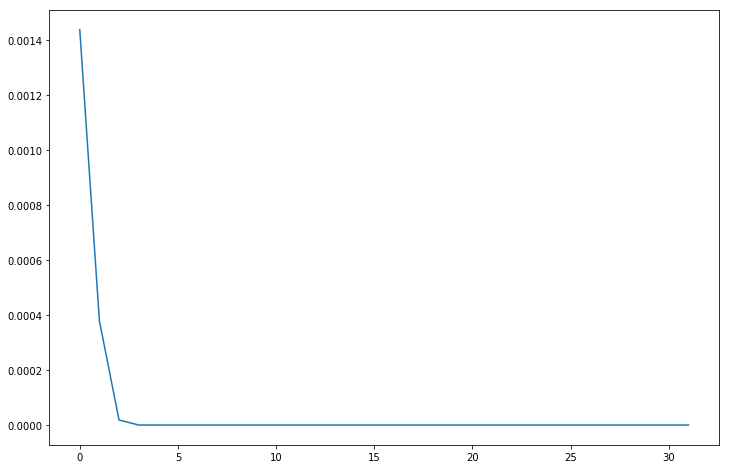

In [21]:
myNodes[0] = 1.0
mySigOut = []
imDim =int(np.sqrt(myDim))
for m in range(32):
    myNodes = ((np.dot(np.sqrt(thetaJ),myNodes)))**2
    ##print(np.shape(myNodes))
    plt.figure(figsize=(6,6))
    plt.imshow(np.reshape(myNodes,(imDim,imDim)))
    
    mySigOut.append(np.dot(((myNodes[myDim-8:myDim])).T,theta1))
plt.figure(figsize=(12,8))
plt.plot(np.reshape(mySigOut,(len(mySigOut),1)))
plt.show()

/home/main/anaconda3/envs/lV/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


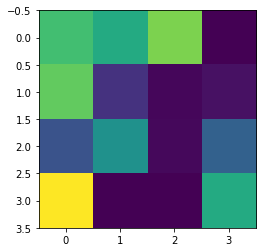

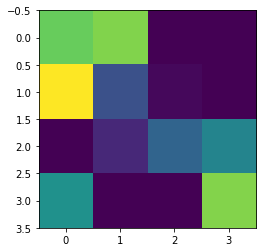

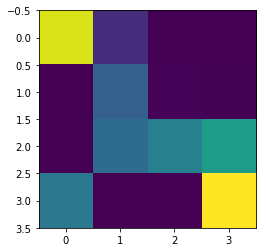

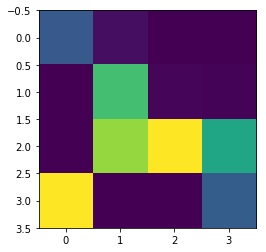

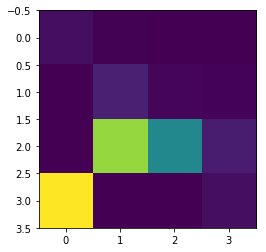

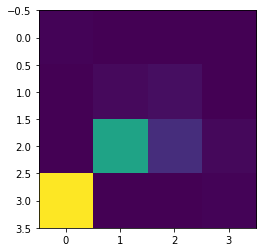

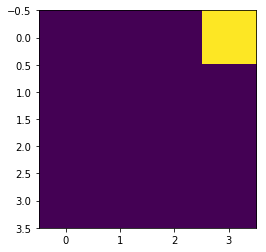

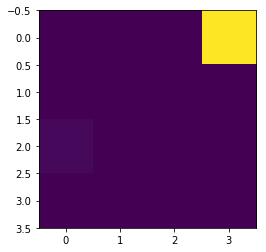

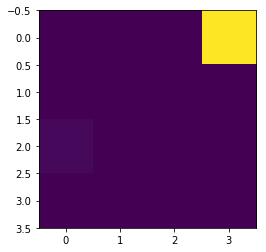

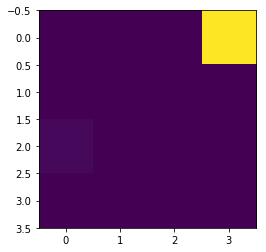

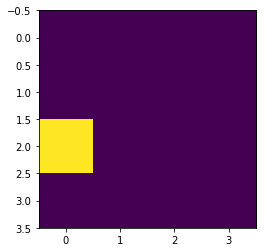

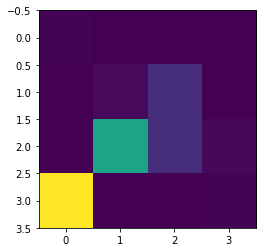

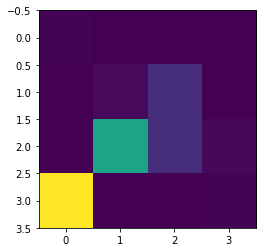

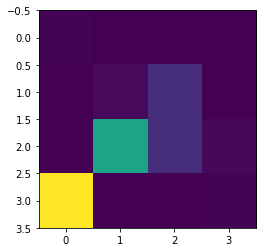

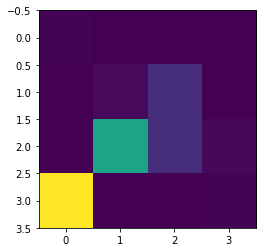

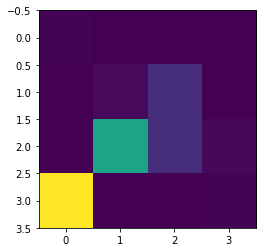

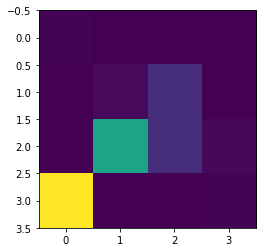

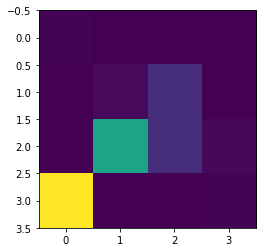

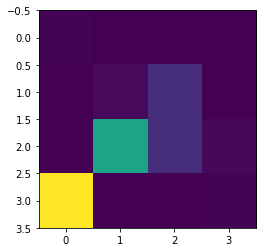

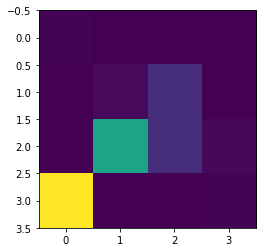

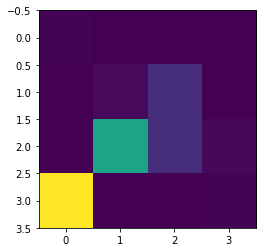

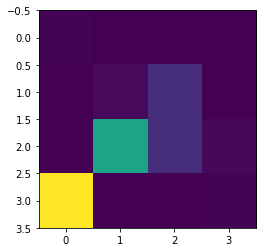

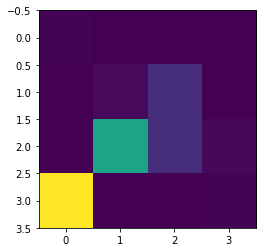

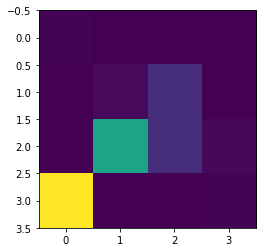

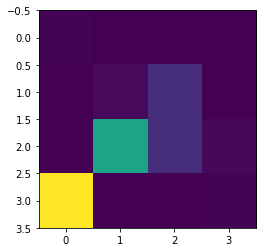

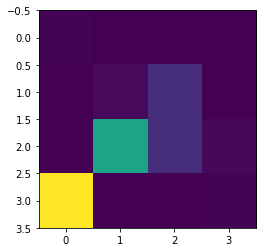

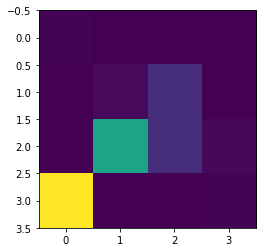

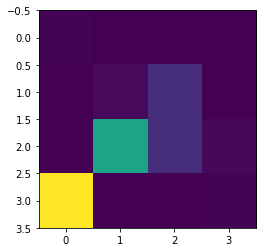

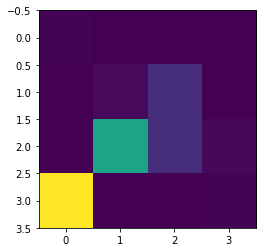

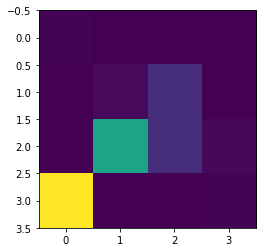

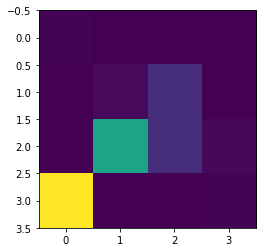

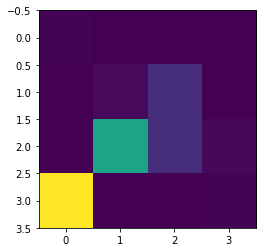

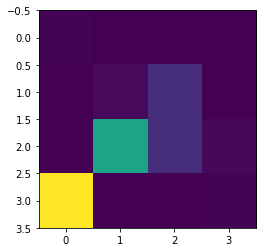

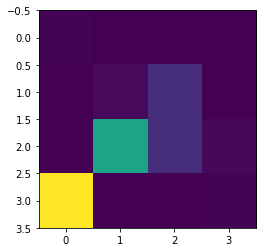

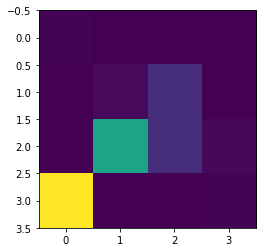

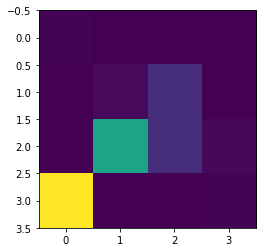

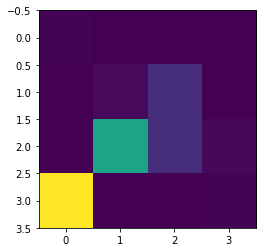

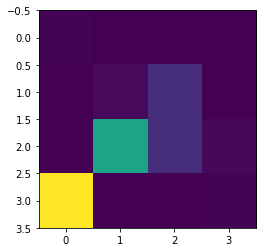

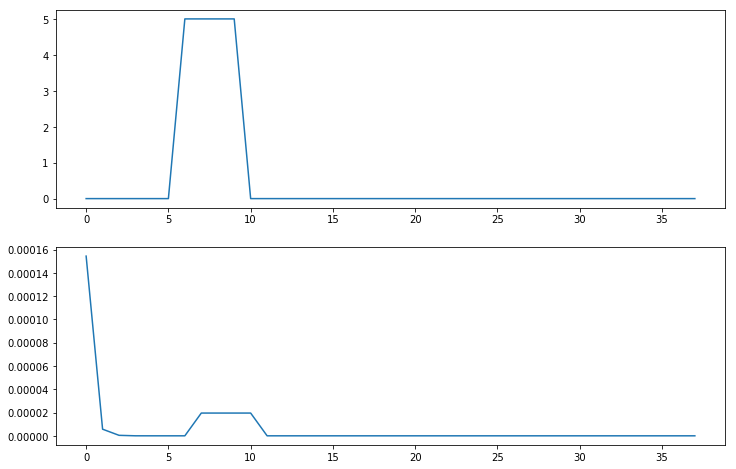

In [42]:
mySigOut = []
testD = int(np.sqrt(myDim))
for l in range(len(mySig)):
    myNodes[0] = mySigD[l]
    myNodes = ((np.dot(thetaJ,myNodes)))
    ##print(np.shape(myNodes))
    plt.figure()
    #plt.subplot(121)
    plt.imshow(np.reshape((myNodes),(testD,testD)))#,vmin=0,vmax=100)
    ##plt.subplot(122)
    #plt.imshow(np.reshape(np.imag(myNodes),(4,4)))#,vmin=0,vmax=100)
    #plt.savefig('./testFig%i'%l)
    mySigOut.append(np.dot(((myNodes[myDim-8:myDim])).T,theta1))
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(mySigD)
#plt.axis([4,40,-0.01,10])
plt.subplot(212)
plt.plot(np.reshape(mySigOut,(len(mySig),1)))

#plt.axis([4,40,-0.01,10])
plt.show()
    

In [120]:
np.sqrt(4096)

64.0

In [86]:
print(reLU(myNodes))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [60]:
np.shape(myNodes)

(64, 1)

In [43]:
print(np.mean(thetaJ))

(0.000102497133644+5.54104166207e-05j)
